## Docker Spark setup

This notebook is meant to run on a spark 2 docker container. First i'll describe the steps to set it up.

On a Linux based system install Docker and Docker-compose.Create this file : docker-compose.yml. The contents is listed below.  Then run: docker-compose build . Afterwards run this command : docker-compose build -d



```
version: "2"

services:
  master:
    image: singularities/spark
    command: start-spark master
    hostname: master
    ports:
      - "6066:6066"
      - "7070:7070"
      - "8080:8080"
      - "50070:50070"
      - "8888:8888"
  worker:
    image: singularities/spark
    command: start-spark worker master
    environment:
      SPARK_WORKER_CORES: 1
      SPARK_WORKER_MEMORY: 2g
    links:
      - master
```

```
With docker ps , check if the master and worker containers are running.
Connect to the master node:
docker exec -it [container id master] bash
On the master node continue with setting up as described below.
```

## Spark and conda env setup

```
First install Anaconda 4 (latest version) on the Docker container with Spark Master. Then install a new Conda environment for Spark, using python 3.5 (3.6 has a bug).  

conda create -n spark python=3.5
source activate spark
conda install notebook ipykernel
ipython kernel install --user --name spark --display-name spark

Make jupyter start script, and run it:
PYSPARK_PYTHON=/root/anaconda3/envs/spark/bin/python
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS='notebook --ip=0.0.0.0 --port=8888' $SPARK_HOME/bin/pyspark

Now go to the url it gives (http://0.0.0.0:8888/<some code>)
, Run the nodebook sections.
```


In [2]:
#Start this in spark conda env to test
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
import pyspark.sql.functions as fn
import pyspark.sql.types as typ

## Example data

```
This example works if you clone https://github.com/PacktPublishing/Learning-PySpark

and make sure its in /root/learningPySpark on the Docker container with Spark Master. 

To install git on this container run command: apt-get install git
, on github (or bitbucket) create a repository so you can save changes from the container and push it to Github. Use the following commands on the Docker container to init and push the data :

git init
git add <your file>
git commit -m "first commit"
git remote add origin https://github.com/michelnossin/pyspark_training_docker.git
git push -u origin master
```

In [3]:
#RANDOM FLIGHTS SET, AND WORLD AIRPORT SET
flights = "file:/root/learningPySpark/Chapter03/flight-data/departuredelays.csv" 
airports = "file:/root/learningPySpark/Chapter03/flight-data/airport-codes-na.txt" 
airports_df = spark.read.csv(airports,header='true',inferSchema='true',sep='\t')
airports_df.createOrReplaceTempView("airports")
flights_df = spark.read.csv(flights,header='true')
flights_df.createOrReplaceTempView("flights")
flights_df.cache()

DataFrame[date: string, delay: string, distance: string, origin: string, destination: string]

In [4]:
#RADAR TRACK
track_file = "file:/root/fr24/fr24_20160624.csv"
header=['na','altitude','dest','heading','flight','na2','landed','time','lat',\
         'lon','na3','org','na4','registration','flight2','speed','na6','planetype', 'altitude_delta']
fields = [ *[
           typ.StructField(h, typ.StringType(), True)
           for h in header
       ]
   ]
schema = typ.StructType(fields)
schema   
tracks_df = spark.read.csv(track_file,header='false',schema=schema)

#filter tracks early to make it speed up
tracks_df = tracks_df.where("dest == 'AMS'") #14 milj -> 114k
tracks_df.createOrReplaceTempView("tracks")
tracks_df.cache()

DataFrame[na: string, altitude: string, dest: string, heading: string, flight: string, na2: string, landed: string, time: string, lat: string, lon: string, na3: string, org: string, na4: string, registration: string, flight2: string, speed: string, na6: string, planetype: string, altitude_delta: string]

## First look at data:

```
source activate spark
python -m pip install pandas
```

In [5]:
import pandas as pd
import matplotlib

In [5]:
spark.sql("select count(1) from flights").show()
spark.sql("select count(1) from airports").show()
spark.sql("select count(1) from tracks").show()

+--------+
|count(1)|
+--------+
| 1391578|
+--------+

+--------+
|count(1)|
+--------+
|     526|
+--------+

+--------+
|count(1)|
+--------+
|  114728|
+--------+



In [6]:
flights_df.limit(5).toPandas()

,date,delay,distance,origin,destination
0,01011245,6,602,ABE,ATL
1,01020600,-8,369,ABE,DTW
2,01021245,-2,602,ABE,ATL
3,01020605,-4,602,ABE,ATL
4,01031245,-4,602,ABE,ATL


In [7]:
airports_df.limit(5).toPandas()

,City,State,Country,IATA
0,Abbotsford,BC,Canada,YXX
1,Aberdeen,SD,USA,ABR
2,Abilene,TX,USA,ABI
3,Akron,OH,USA,CAK
4,Alamosa,CO,USA,ALS


In [ ]:
tracks_df.limit(5).toPandas()

In [8]:
airports_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)



In [9]:
flights_df.printSchema() #date, delay and distance should change to int

root
 |-- date: string (nullable = true)
 |-- delay: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)



In [50]:
tracks_df.printSchema()

root
 |-- na: string (nullable = true)
 |-- altitude: integer (nullable = true)
 |-- dest: string (nullable = true)
 |-- heading: integer (nullable = true)
 |-- flight: string (nullable = true)
 |-- na2: string (nullable = true)
 |-- landed: integer (nullable = true)
 |-- time: long (nullable = true)
 |-- lat: long (nullable = true)
 |-- lon: long (nullable = true)
 |-- na3: string (nullable = true)
 |-- org: string (nullable = true)
 |-- na4: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- flight2: string (nullable = true)
 |-- speed: integer (nullable = true)
 |-- na6: string (nullable = true)
 |-- planetype: string (nullable = true)
 |-- altitude_delta: integer (nullable = true)



## Cleaning data

Your data can be stained with duplicates, missing observations and outliers, non- existent addresses, wrong phone numbers and area codes, inaccurate geographical coordinates, wrong dates, incorrect labels, mixtures of upper and lower cases, trailing spaces, and many other more subtle problems. It is your job to clean it, irrespective of whether you are a data scientist or data engineer,

### Duplicate rows check and remove
First lets define some our spark util functions

In [6]:
def showDuplicateRowsCount(df):
    'Show row count with full duplicated rows'
    print("====Checking table duplicate rows =====")
    print('Count of rows: {0}'.format(df.count()))
    print('Count of distinct rows: {0}'.format(df.distinct().count()))
    print('===> nr of duplicate rows {0}'.format(df.count()-df.distinct().count()))
def showDuplicatesColumnCount(df,col):
    'Show duplicate rows based on a specific (id) col.'
    print("=====Checking col {0}".format(col))
    print('Count of values: {0}'.format(df.count()))
    distinct_col_count = df.select([
           c for c in df.columns if c != col
       ]).distinct().count()
    print('Count of distinct column values: {0}'.format(distinct_col_count))
    print ("====> duplicate count {0}".format(df.count() - distinct_col_count))
def showDuplicatesColumnCountSpark(df,col):
    'spark version of Showduplicatescolumncount()'
    df.agg(
       fn.count(col).alias('count'),
       fn.countDistinct(col).alias('distinct')
    ).show()
def showDuplicateColumnsCount(df):
    'Show duplicate rows based on all columns in a dataframe'
    for col in df.columns:
        showDuplicatesColumn(df,col)
def dropDuplicateColumn(df,col):
    'drop rows with duplicate columns based on certain (id) column'
    df = df.dropDuplicates(subset=[
       c for c in df.columns if c != col
    ])
#   
#def getDFDuplicateColumns(df,col,new_col):
#    uniq_df = df.select([
#           c for c in df.columns if c != col
#       ]).distinct()
#    duplicate_df = df.subtract(uniq_df)
#    
#    return(duplicate_df.withColumn(new_col, \
#                            fn.monotonically_increasing_id()))
#   **/ 
def showMissingDataPercent(df_miss):
    'show each column and percentage of missing data, 0 - 1 , 0 means no missing data'
    df_miss.agg(*[
       (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
       for c in df_miss.columns
    ]).show()
def getDFDropColumn(df_miss,col):
    'Get a new dataframe based on another without given column'
    return(df_miss.select([
       c for c in df_miss.columns if c != col
    ]))
def getDFDropMissingRows(df_miss):
    'Drop rows with any missing column field'
    return(df_miss.dropna())
def fillMissingMeanColumn(df,col):
    'Fill in missing values in a certain column containing numerical data'
    means = df.agg(
       *[fn.mean(col).alias(col)
           for c in df.columns if c != col]
   ).toPandas().to_dict('records')[0]
def getDFFillMissingCategoryColumn(df,col):
    'Fill in missing values in a column containing a category and return df'
    miss_dict = {col: "missing"}
    return(df.fillna(miss_dict))
def getDictOutliers(df_outliers,col_list):
    'return dictionary with outliers boundaries , based on columns in list'
    bounds = {}
    for col in col_list:
        quantiles = df_outliers.approxQuantile(
           col, [0.25, 0.75], 0.05
       )
        IQR = quantiles[1] - quantiles[0]
        bounds[col] = [
           quantiles[0] - 1.5 * IQR,
           quantiles[1] + 1.5 * IQR
     ]
    return bounds
def getDFOutliers(df_outliers,bounds,cols,id_col):
    'print all outlier rows based on dictionary with outlier bounderies dict, for columns in column list'
    outliers = df_outliers.select(*[id_col] + [
       (
           (df_outliers[c] < bounds[c][0]) |
           (df_outliers[c] > bounds[c][1])
       ).alias(c + '_o') for c in cols
    ])
    return outliers

    

In [12]:
#Check duplicates rows, same value?
flights_df = spark.sql("select * from flights") #507 out of 1.4 milj
showDuplicateRowsCount(flights_df)
airports_df = spark.sql("select * from airports") #0
showDuplicateRowsCount(airports_df)
tracks_df = spark.sql("select * from tracks") #192k out of 14m, 735 out of 114k after filtering for AMS arrival
showDuplicateRowsCount(tracks_df) #takes 10 mins

====Checking table duplicate rows =====
Count of rows: 1391578
Count of distinct rows: 1391071
===> nr of duplicate rows 507
====Checking table duplicate rows =====
Count of rows: 526
Count of distinct rows: 526
===> nr of duplicate rows 0
====Checking table duplicate rows =====
Count of rows: 114728
Count of distinct rows: 113993
===> nr of duplicate rows 735


In [7]:
#Change type of integer based columns , so we check outliers later on
flights_df = flights_df.withColumn("delay",flights_df["delay"].cast(typ.IntegerType()))
flights_df = flights_df.withColumn("distance",flights_df["distance"].cast(typ.IntegerType()))
                   
tracks_df = tracks_df.withColumn("altitude",tracks_df["altitude"].cast(typ.IntegerType()))  
tracks_df = tracks_df.withColumn("altitude_delta",tracks_df["altitude_delta"].cast(typ.IntegerType()))
tracks_df = tracks_df.withColumn("speed",tracks_df["speed"].cast(typ.IntegerType()))      
tracks_df = tracks_df.withColumn("heading",tracks_df["heading"].cast(typ.IntegerType()))   
tracks_df = tracks_df.withColumn("lat",tracks_df["lat"].cast(typ.FloatType()))  
tracks_df = tracks_df.withColumn("lon",tracks_df["lon"].cast(typ.FloatType())) 
tracks_df = tracks_df.withColumn("time",tracks_df["time"].cast(typ.LongType())) 
tracks_df = tracks_df.withColumn("landed",tracks_df["landed"].cast(typ.IntegerType()))

#Lets add a id columns for the flights
flights_df = flights_df.withColumn('id',fn.monotonically_increasing_id())

In [7]:
#pure duplicates just drop these, but the flights tables might be different flights. We donts know without id
tracks_df =tracks_df.dropDuplicates()

### Duplicate columns check

Some times there are columns identifying a row, and which are different.
However in case you know the rest of the columns is the same you might want to remove these rows. eg , Michel , 1.90, hoofddorp , and michel2, 1.90, hoofddorp . Its the same person but id is incorrect. 

In [15]:
#airports IATA should be uniq. It seems 15 rows have identical data 
#but different IATA code
showDuplicatesColumnCount(airports_df,'IATA')
showDuplicatesColumnCountSpark(airports_df,'IATA')
#TODO WHY ARE RESULT DIFFERENT!!!!!! SHOULD BE BOTH 511 OR 524!!

=====Checking col IATA
Count of values: 526
Count of distinct column values: 511
====> duplicate count 15
+-----+--------+
|count|distinct|
+-----+--------+
|  526|     524|
+-----+--------+



In [16]:
showDuplicatesColumnCount(tracks_df,'flight')

=====Checking col flight
Count of values: 113993
Count of distinct column values: 113993
====> duplicate count 0


```
We could call dropDuplicateColumn(df_airports,'IATA')

However this would delete rows without knowing the correct IATA. 
The Flights tables does not have uniq field like flightname,
so will not delete any rows there either.
```

In [ ]:
#TODO: Make function to show these rows so we know which are duplicates
#df_duplicate_airports = getDFDuplicateColumns(airports_df,'IATA','new_id')
#df_duplicate_airports.toPandas()

### Missing data

```
Drop data row if possible in case of missing. if datasize. < 50% check which features are missing, and just drop these.
Alternative impute missing:
Boolean: add missing category
categorial already: add multiple extra levels and and missing there
numeric and ordinal: mean, median etc to fill in
```

In [16]:
#0 = perfect, 1 = all is missing
showMissingDataPercent(airports_df) #State misses some data
showMissingDataPercent(flights_df)
showMissingDataPercent(tracks_df) #We miss some, flight a bit, but is important to have these,

+------------+--------------------+---------------+------------+
|City_missing|       State_missing|Country_missing|IATA_missing|
+------------+--------------------+---------------+------------+
|         0.0|0.005703422053231932|            0.0|         0.0|
+------------+--------------------+---------------+------------+

+------------+-------------+----------------+--------------+-------------------+----------+
|date_missing|delay_missing|distance_missing|origin_missing|destination_missing|id_missing|
+------------+-------------+----------------+--------------+-------------------+----------+
|         0.0|          0.0|             0.0|           0.0|                0.0|       0.0|
+------------+-------------+----------------+--------------+-------------------+----------+

+----------+----------------+------------+---------------+--------------------+-----------+--------------+------------+-----------+-----------+--------------------+-----------+-----------+--------------------+----

In [8]:
#We could just drop column state, we keep all our rows, and have no missing data
df_no_state = getDFDropColumn(airports_df,'State')
showMissingDataPercent(df_no_state)

df_no_flight = getDFDropColumn(tracks_df,'flight')
showMissingDataPercent(df_no_flight)

df_no_flight.count() #113993 out of 114k

+------------+---------------+------------+
|City_missing|Country_missing|IATA_missing|
+------------+---------------+------------+
|         0.0|            0.0|         0.0|
+------------+---------------+------------+

+----------+----------------+------------+---------------+-----------+--------------+------------+-----------+-----------+--------------------+-----------+-----------+--------------------+--------------------+-------------+-----------+-----------------+----------------------+
|na_missing|altitude_missing|dest_missing|heading_missing|na2_missing|landed_missing|time_missing|lat_missing|lon_missing|         na3_missing|org_missing|na4_missing|registration_missing|     flight2_missing|speed_missing|na6_missing|planetype_missing|altitude_delta_missing|
+----------+----------------+------------+---------------+-----------+--------------+------------+-----------+-----------+--------------------+-----------+-----------+--------------------+--------------------+-------------+--

114728

In [9]:
#Or drop only rows with any missing data
df_without_missing = getDFDropMissingRows(airports_df)
showMissingDataPercent(df_without_missing)

df_without_missing_flight = getDFDropMissingRows(tracks_df)
showMissingDataPercent(df_without_missing_flight)

df_without_missing_flight.count() #Also 113167 , so we could just use this for the tracker

+------------+-------------+---------------+------------+
|City_missing|State_missing|Country_missing|IATA_missing|
+------------+-------------+---------------+------------+
|         0.0|          0.0|            0.0|         0.0|
+------------+-------------+---------------+------------+

+----------+----------------+------------+---------------+--------------+-----------+--------------+------------+-----------+-----------+-----------+-----------+-----------+--------------------+---------------+-------------+-----------+-----------------+----------------------+
|na_missing|altitude_missing|dest_missing|heading_missing|flight_missing|na2_missing|landed_missing|time_missing|lat_missing|lon_missing|na3_missing|org_missing|na4_missing|registration_missing|flight2_missing|speed_missing|na6_missing|planetype_missing|altitude_delta_missing|
+----------+----------------+------------+---------------+--------------+-----------+--------------+------------+-----------+-----------+-----------+----

113896

In [10]:
#Or we can impute values, as this is a category we will add a missing category
df_missing_state = getDFFillMissingCategoryColumn(airports_df,'State')
df_missing_state.where("State == 'missing'").show() #3
df_missing_state.count() #526
showMissingDataPercent(df_missing_state)

+-------------+-------+-------+----+
|         City|  State|Country|IATA|
+-------------+-------+-------+----+
|Washington DC|missing|    USA| IAD|
|Washington DC|missing|    USA| DCA|
|Washington DC|missing|    USA| WAS|
+-------------+-------+-------+----+

+------------+-------------+---------------+------------+
|City_missing|State_missing|Country_missing|IATA_missing|
+------------+-------------+---------------+------------+
|         0.0|          0.0|            0.0|         0.0|
+------------+-------------+---------------+------------+



In [11]:
#LETS PICK LAST OPTION for Airports and trackers
airports_df = df_missing_state
tracks_df = df_without_missing_flight

### outliers

Outliers are those observations that deviate signi cantly from the distribution of the rest of your sample. The de nitions of signi cance vary, but in the most general form, you can accept that there are no outliers if all the values are roughly within the Q1−1.5IQR and Q3+1.5IQR range

In [20]:
#Show the ouytlier ranges for our integer based columns
col_list = ['delay','distance'] 

#Run cast code in the beginning again (dont no why thats needed?)
outliers_dict = getDictOutliers(flights_df,col_list)
print(outliers_dict) 

#Show the ouytlier ranges for our integer based columns
col_flights_list = ['lat','lon','altitude','heading','time','landed'] 

outliers_flights_dict = getDictOutliers(tracks_df,col_flights_list)
print(outliers_flights_dict) #Not really handy way to check outliers.



{'distance': [-518.5, 1813.5], 'delay': [-32.5, 43.5]}
{'landed': [0.0, 0.0], 'heading': [-266.0, 654.0], 'lon': [-31.0, 49.0], 'lat': [38.0, 62.0], 'time': [1466689917.0, 1466841293.0], 'altitude': [-19087.5, 70612.5]}


In [21]:
#Flag rows
#Run the id add function again, for some reason..
df_outliers = getDFOutliers(flights_df,outliers_dict,col_list,'id')
df_outliers.show()

df_flight_outliers = getDFOutliers(tracks_df,outliers_flights_dict,col_flights_list,'flight')
df_flight_outliers.show()

+---+-------+----------+
| id|delay_o|distance_o|
+---+-------+----------+
|  0|  false|     false|
|  1|  false|     false|
|  2|  false|     false|
|  3|  false|     false|
|  4|  false|     false|
|  5|  false|     false|
|  6|  false|     false|
|  7|  false|     false|
|  8|   true|     false|
|  9|  false|     false|
| 10|  false|     false|
| 11|   true|     false|
| 12|  false|     false|
| 13|  false|     false|
| 14|  false|     false|
| 15|  false|     false|
| 16|  false|     false|
| 17|  false|     false|
| 18|  false|     false|
| 19|  false|     false|
+---+-------+----------+
only showing top 20 rows

+------+-----+-----+----------+---------+------+--------+
|flight|lat_o|lon_o|altitude_o|heading_o|time_o|landed_o|
+------+-----+-----+----------+---------+------+--------+
| KL214|false| true|     false|    false| false|   false|
| UA909|false| true|     false|    false| false|   false|
| KL642|false| true|     false|    false| false|   false|
|MP6332|false| true|     f

In [22]:
#Show outlier  flights
#1.4 milj flights, about 162k has outlier delays. And 75k outlier distance
df_out= flights_df.join(df_outliers, on='id')
print(df_out.filter('delay_o').select('id', 'delay').count())
print(df_out.filter('distance_o').select('id', 'distance').count())
df_out.filter('delay_o').select('id', 'delay').show()
df_out.filter('distance_o').select('id', 'distance').show()
    

136256
74877
+---+-----+
| id|delay|
+---+-----+
|  8|   88|
| 11|   69|
| 23|   54|
| 25|  151|
| 29|   83|
| 34|   52|
| 36|  127|
| 63|   68|
| 80|   89|
| 82|   44|
| 85|   80|
| 87|  333|
| 88|  219|
| 92|  180|
|121|   92|
|138|   47|
|170|  146|
|174|   72|
|177|   62|
|181|  150|
+---+-----+
only showing top 20 rows

+----+--------+
|  id|distance|
+----+--------+
|3685|    1944|
|3691|    1944|
|3703|    1944|
|3722|    1944|
|3728|    1944|
|3738|    1944|
|4710|    2473|
|4714|    2038|
|4716|    2217|
|4721|    2413|
|4744|    2473|
|4749|    2038|
|4752|    2002|
|4760|    2430|
|4761|    2413|
|4785|    2473|
|4790|    2038|
|4792|    2002|
|4800|    2413|
|4820|    2473|
+----+--------+
only showing top 20 rows



In [23]:
#Show outlier  tracks, dont understand the result yet .. todo
df_out=tracks_df.join(df_flight_outliers, on='flight')
print(df_out.filter('heading_o').select('flight', 'heading').count())  #None, however heading has strange values
print(df_out.filter('altitude_o').select('flight', 'altitude').count()) #None, but shows some strange numbers
print(df_out.filter('lat_o').select('flight', 'lat').count()) #32, < 33 but still good value
print(df_out.filter('lon_o').select('flight', 'lon').count()) #-66 also good
print(df_out.filter('landed_o').select('flight', 'landed').count())  # 0 , <> 0.0 .. 

df_out.filter('heading_o').select('flight', 'heading').show()
df_out.filter('altitude_o').select('flight', 'altitude').show()
df_out.filter('lat_o').select('flight', 'lat').show()
df_out.filter('lon_o').select('flight', 'lon').show()
df_out.filter('landed_o').select('flight', 'landed').show()

0
0
6839920
14994563
2369013
+------+-------+
|flight|heading|
+------+-------+
+------+-------+

+------+--------+
|flight|altitude|
+------+--------+
+------+--------+

+------+---+
|flight|lat|
+------+---+
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
| KL836| 38|
+------+---+
only showing top 20 rows

+------+----+
|flight| lon|
+------+----+
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
| KL214|-122|
+------+----+
only showing top 20 rows

+------+------+
|flight|landed|
+------+------+
| KL214|     0|
| KL214|     0|
| KL214|     0|
| KL214|     0|
| KL214|     0|
|

In [12]:
#Lets filters in between known ranges:
#landed 0 or 1
#heading 0 - 360
#altitude < 100 , > 50000 
#the valid range of latitude in degrees is -90 and +90 . Longitude is in the range -180 and +180 
tracks_df = tracks_df.where("landed == 0 or landed == 1")
tracks_df = tracks_df.where("heading >= 0 and heading < 360")
tracks_df = tracks_df.where("altitude > -100 and altitude < 50000")
tracks_df = tracks_df.where("lat >= -90 and lat <= 90")
tracks_df = tracks_df.where("lon >= -180 and lon <= 180")
tracks_df.count() #only 1 row removed 113992

tracks_df.describe().toPandas() #looks fine


,summary,na,altitude,dest,heading,flight,na2,landed,time,lat,lon,na3,org,na4,registration,flight2,speed,na6,planetype,altitude_delta
0,count,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895,113895
1,mean,0.0,25839.52904868519,None,185.30038193072568,None,None,0.10817858553931252,1.4667654668721278E9,47.24085907468024,5.819629015750844,1.6239558107262378E68,None,None,None,None,387.24444444444447,2875.562728829185,None,-18.260187014355328
2,stddev,0.0,14130.439588931717,None,116.4537596666319,None,None,0.3106071896112035,23852.197419766166,11.231276713310306,42.39445431450008,2.562628915319931E69,None,None,None,None,160.23391600738867,2403.6375205577956,None,964.3760531794654
3,min,0,0,AMS,0,4U2180,a1dd1a8,0,1466724663,-34.0329,-123.4047,010145,AAL,F-BGGH2,4X-BAW,AAL798,0,0000,A306,-30976
4,max,0,43000,AMS,359,Y87486,a21c811,1,1466811193,70.1904,140.5139,C053F6,ZTH,T-ZYTL4,YU-APG,YZR7486,688,7761,RJ85,30976


## Example flight

In [13]:
df_sel = tracks_df.where("flight == 'KL836'").toPandas().sort_values(['time']).reset_index() #515 rows
df_sel

,index,na,altitude,dest,heading,flight,na2,landed,time,lat,lon,na3,org,na4,registration,flight2,speed,na6,planetype,altitude_delta
0,0,0,32000,AMS,311,KL836,a1e0c3f,0,1466724683,35.678299,60.430801,485000,SIN,F-OIMM1,PH-BVK,KLM836,451,0000,B77W,0
1,1,0,32000,AMS,311,KL836,a1e0c3f,0,1466724741,35.757999,60.319500,485000,SIN,F-OIMM1,PH-BVK,KLM836,452,0000,B77W,0
2,2,0,32000,AMS,311,KL836,a1e0c3f,0,1466724806,35.847599,60.193802,485000,SIN,F-OIMM1,PH-BVK,KLM836,452,0000,B77W,-64
3,3,0,32000,AMS,311,KL836,a1e0c3f,0,1466724867,35.931900,60.075199,485000,SIN,F-OIMM1,PH-BVK,KLM836,452,0000,B77W,0
4,4,0,32000,AMS,310,KL836,a1e0c3f,0,1466724931,36.020802,59.949501,485000,SIN,F-OIMM1,PH-BVK,KLM836,453,0000,B77W,0
5,5,0,32000,AMS,310,KL836,a1e0c3f,0,1466724990,36.101002,59.835899,485000,SIN,F-OIMM1,PH-BVK,KLM836,453,0000,B77W,0
6,6,0,32000,AMS,310,KL836,a1e0c3f,0,1466725055,36.189999,59.709000,485000,SIN,F-OIMM1,PH-BVK,KLM836,453,0000,B77W,0
7,7,0,32000,AMS,304,KL836,a1e0c3f,0,1466725113,36.264500,59.591301,485000,SIN,F-OIMM1,PH-BVK,KLM836,449,0000,B77W,0
8,8,0,32000,AMS,304,KL836,a1e0c3f,0,1466725178,36.342899,59.451302,485000,SIN,F-OIMM1,PH-BVK,KLM836,451,0000,B77W,-64
9,9,0,32000,AMS,304,KL836,a1e0c3f,0,1466725242,36.418900,59.314701,485000,SIN,F-OIMM1,PH-BVK,KLM836,451,0000,B77W,0


In [14]:
from IPython.display import HTML
import folium

%matplotlib inline
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))
 
def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

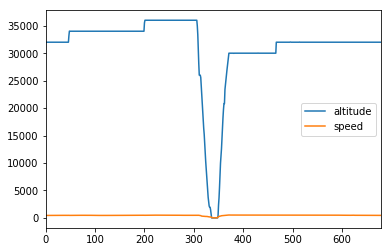

In [15]:
import matplotlib
#matplotlib.style.use('ggplot')
df_sel[['altitude','speed']].plot()

In [16]:

import sys
import folium

from IPython.display import HTML


def display(m, height=300):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    #map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

In [47]:
import folium
from IPython.display import HTML
def plotFlight(flight):
    df_sel = tracks_df.where("flight == '" + flight + "'").toPandas().sort_values(['time']).reset_index()
    #df_sel = join_df.toPandas().query("flight == '" + flight + "'").sort_values(['time']).reset_index()
    fmap=folium.Map(location=[52.308871, 4.761392], zoom_start=4)
    #for row in df_sel.iterrows():
     #   latlon = [ row[1]['lat'], row[1]['lon'] ]
    #   folium.Marker(latlon, popup=str(row[1]['time'])).add_to(fmap)
     #   fmap.add_children
    
    
    latlist = df_sel['lat'].tolist()
    lonlist = df_sel['lon'].tolist()
    coordinates = zip(latlist[:], lonlist[:])
    line=folium.PolyLine(locations=coordinates,weight=3,color = 'red')
    fmap.add_children(line)
    fmap.save('osm.html')
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path='osm.html'))

In [46]:
plotFlight('Y87486')
#plotFlight('KL214')
#plotFlight('KL836')
#plotFlight('U26771')

/root/anaconda3/envs/spark/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


### Statistics

In [90]:
#read in the file
flights = "file:/root/learningPySpark/Chapter03/flight-data/departuredelays.csv" 
fl = sc.textFile(flights) #you can use .gz, so better then spark sql
header = fl.first()
header

'date,delay,distance,origin,destination'

In [91]:

#Filter numeric columns in flights
fl_filter = fl.filter(lambda row: row != header) \
       .map(lambda row: [int(elem) for elem in row.split(',') if (elem.isdigit() or elem.lstrip("-").isdigit()) ])
fl_filter.take(5) #.foreach(println)

[[1011245, 6, 602],
 [1020600, -8, 369],
 [1021245, -2, 602],
 [1020605, -4, 602],
 [1031245, -4, 602]]

In [94]:
#create schema
fields = [ *[
           typ.StructField(h, typ.IntegerType(), True)
           for h in header.split(',')
       ]
   ]
schema = typ.StructType(fields)
schema   

StructType(List(StructField(date,IntegerType,true),StructField(delay,IntegerType,true),StructField(distance,IntegerType,true),StructField(origin,IntegerType,true),StructField(destination,IntegerType,true)))

In [97]:
#create DF Spark
fli_df = spark.createDataFrame(fl_filter, schema)
fli_df.printSchema()
#fli_df.show() Some columns are not integer so crash, to fix later

root
 |-- date: integer (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: integer (nullable = true)
 |-- destination: integer (nullable = true)



In [98]:
#to group by values within a column
tracks_df.groupby('flight').count().show()

+------+-----+
|flight|count|
+------+-----+
| DL138|  418|
|CND518|  136|
| BE111|   47|
|MP6742|   48|
|U28881|   59|
|KL1742|   50|
| KL888|  681|
| OR288|  180|
|KL1858|   33|
|KL1134|   81|
|KL1800|   72|
|KL1618|  101|
|KL1688|   78|
|KL1790|   79|
| KL736|  191|
|U27908|   94|
|KL1168|  133|
|KL1010|   72|
| LH992|   76|
| LX736|   94|
+------+-----+
only showing top 20 rows



In [101]:
#grouping the whole set and perform function
tracks_df.agg({'speed' : 'skewness'}).show() #ratio mean to sd is very low, wide spread observation negatively

#can also use: avg(), count(), countDistinct(), first(), kurtosis(), max(), mean(), min(), skewness(), stddev(), stddev_pop(), stddev_samp(), sum(), sumDistinct(), var_pop(), var_samp() and variance().



+-------------------+
|    skewness(speed)|
+-------------------+
|-1.3184221374471012|
+-------------------+



In [102]:
#correlation is simple (only pearson , and in pairs)
tracks_df.corr('landed','speed') #quit some relation which you expect

-0.8008596136475626

In [107]:
def showCorrelationMatrix(df,numerical):
    'for a DF print matrix with correlations between all numerical columns'
    n_numerical = len(numerical)
    corr = []
    for i in range(0, n_numerical):
        temp = [None] * i
        for j in range(i, n_numerical):
            temp.append(df.corr(numerical[i], numerical[j]))
        corr.append(temp)
        
    print(corr)

In [109]:
showCorrelationMatrix(tracks_df,['speed','landed','altitude','heading'])

[[1.0, -0.8008596136475625, 0.9091355536746628, 0.023498511180720928], [None, 1.0, -0.6314029543734357, -0.10356934806181088], [None, None, 1.0, 0.1246523841879872], [None, None, None, 1.0]]


In [111]:
tracks_df.corr('speed','altitude') #very high correlation

0.9091355536746633

### Lets try to make some features
```
Flight,time,speed,distance_to_ams,time_till_actual_landing

distance to amsterdam , will be lat/lon comparison to lat/lon ams airport
for each row
```

In [17]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

#This will be slow in pyspark due to context switching JVM and pyspark
#Better to use UDF, or use Scala etc
def dist_to_ams(lat,lon):
    return haversine(float(4.761392), float(52.308871), float(lon),float(lat))

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

udf_func = udf(dist_to_ams, FloatType())
tracks_df = tracks_df.withColumn("distance_to_ams", \
                            udf_func(tracks_df.lat,tracks_df.lon))


In [19]:
#Distance is great, however, after landing, the next row is the NEXT
# flight
df = tracks_df.where("flight == 'KL214'").toPandas().sort_values(['time']).reset_index()
df.head(5)

,index,na,altitude,dest,heading,flight,na2,landed,time,lat,...,na3,org,na4,registration,flight2,speed,na6,planetype,altitude_delta,distance_to_ams
0,0,0,23300,AMS,65,KL214,a1ed142,0,1466724679,49.265800,...,484CBB,YVR,T-KNOW2,PH-BVG,KLM214,423,2623,B77W,1856,7646.336426
1,1,0,24425,AMS,66,KL214,a1ed142,0,1466724740,49.314602,...,484CBB,YVR,T-KNOW2,PH-BVG,KLM214,450,2623,B77W,768,7635.384277
2,2,0,25200,AMS,66,KL214,a1ed142,0,1466724805,49.369801,...,484CBB,YVR,T-KNOW2,PH-BVG,KLM214,486,2623,B77W,1152,7622.853027
3,3,0,26775,AMS,66,KL214,a1ed142,0,1466724865,49.427601,...,484CBB,YVR,T-KNOW2,PH-BVG,KLM214,503,2623,B77W,1408,7609.669434
4,4,0,28350,AMS,67,KL214,a1ed142,0,1466724930,49.488098,...,484CBB,YVR,T-KNOW2,PH-BVG,KLM214,517,2623,B77W,1152,7595.764160


In [27]:
#just a test to compare rows
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window

df = (
    sc.parallelize([
        (134, 30, "2016-07-02 12:01:40"), (134, 32, "2016-07-02 12:21:23"),
        (125, 30, "2016-07-02 13:22:56"), (125, 32, "2016-07-02 13:27:07"),
    ]).toDF(["itemid", "eventid", "timestamp"])
    .withColumn("timestamp", col("timestamp").cast("timestamp"))
)

w = Window.partitionBy("itemid").orderBy("timestamp")

diff = col("timestamp").cast("long") - lag("timestamp", 1).over(w).cast("long")

df = df.withColumn("diff", diff)
df.show()

+------+-------+--------------------+----+
|itemid|eventid|           timestamp|diff|
+------+-------+--------------------+----+
|   134|     30|2016-07-02 12:01:...|null|
|   134|     32|2016-07-02 12:21:...|1183|
|   125|     30|2016-07-02 13:22:...|null|
|   125|     32|2016-07-02 13:27:...| 251|
+------+-------+--------------------+----+



In [30]:
#Lets create a delta to get the landing times
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window

df = (
    sc.parallelize([
        ('kl123', 0, "2016-07-02 12:01:40"), ('kl123', 0, "2016-07-02 12:21:23"),
        ('kl123', 1, "2016-07-02 13:22:56"), ('kl123', 1, "2016-07-02 13:27:07"),
    ]).toDF(["itemid", "landed", "timestamp"])
    .withColumn("timestamp", col("timestamp").cast("timestamp"))
)

w = Window.partitionBy("itemid").orderBy("timestamp")

diff = col("landed").cast("int") - lag("landed", 1).over(w).cast("int")

df = df.withColumn("diff", diff)
df.show()

+------+------+--------------------+----+
|itemid|landed|           timestamp|diff|
+------+------+--------------------+----+
| kl123|     0|2016-07-02 12:01:...|null|
| kl123|     0|2016-07-02 12:21:...|   0|
| kl123|     1|2016-07-02 13:22:...|   1|
| kl123|     1|2016-07-02 13:27:...|   0|
+------+------+--------------------+----+



In [20]:
#now lets adds column to show the landing moment, so delta of the landed column should be +1 .
#
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window


w = Window.partitionBy("flight").orderBy("time")

diff = col("landed").cast("int") - lag("landed", 1).over(w).cast("int")

tracks_touchdown_df = tracks_df.select(["flight","time","heading","landed","registration"]).withColumn("touchdown", diff)
tracks_touchdown_df = tracks_touchdown_df.where("touchdown == 1").select(col("flight"), \
                                                                         col("registration"),\
                                                                         col("heading").alias("runway"), \
                                                                         col("time").alias("touchdown_time") )
tracks_touchdown_df.show()

+------+------------+------+--------------+
|flight|registration|runway|touchdown_time|
+------+------------+------+--------------+
|CND518|      PH-CDE|     2|    1466792627|
| DL138|      N836MH|   171|    1466760692|
|MP6742|      PH-MCP|   182|    1466778285|
|KL1742|      PH-KZD|   182|    1466775981|
|U28881|      G-EZDO|   132|    1466793964|
|KL1134|      PH-BGX|   151|    1466796510|
|KL1800|      PH-BGH|   182|    1466801922|
|KL1858|      PH-KZP|   182|    1466777442|
| KL888|      PH-BFP|   132|    1466785238|
| OR288|      PH-TFD|   182|    1466767433|
|KL1618|      PH-BXH|   165|    1466749916|
|KL1790|      PH-BXC|   182|    1466749726|
| KL736|      PH-BFA|   182|    1466743064|
|U27908|      G-EZWP|   177|    1466800107|
|KL1168|      PH-BCB|   160|    1466775337|
|KL1010|      PH-BGO|   154|    1466769724|
| LH992|      D-AIRY|   182|    1466770692|
| LX736|      HB-IPV|   160|    1466799875|
| BT621|      YL-BBE|   154|    1466751644|
|U26771|      G-EZAP|   267|    

In [21]:
#check for multiple landings 1 flight
#tracks_touchdown_df.groupby(["flight","registration"]).count().where("count > 1").show()
tracks_touchdown_df.groupby(["flight"]).count().where("count > 1").show()

+------+-----+
|flight|count|
+------+-----+
|HV6118|    2|
|HV5134|    2|
|KL1412|    2|
|HV6332|    2|
|HV5356|   20|
|HV5314|    2|
| TP668|    2|
|HV6146|    2|
+------+-----+



In [22]:
#remove them
tracks_touchdown_df = tracks_touchdown_df.where("flight != 'HV6118' and flight != 'HV5134' and flight != 'KL1412' and flight != 'HV6332' and flight != 'HV5356' and flight != 'HV5314' and flight != 'TP668' and flight != 'HV6146' ")

In [23]:
#check again
tracks_touchdown_df.groupby(["flight"]).count().where("count > 1").show()

+------+-----+
|flight|count|
+------+-----+
+------+-----+



In [24]:
#join tracks with our landing table and add column showing time till land
join_df = tracks_df.join(tracks_touchdown_df,tracks_df.flight == tracks_touchdown_df.flight)
join_df = join_df.withColumn("time_till_landing",col("touchdown_time") - col("time"))

In [84]:
#get rid of > 7000 sec , so we make sure flights on the next day are not using the landing of current day
#join_df = join_df.where("time_till_landing > -7000")
join_df = join_df.where("time_till_landing > 0") #ML REQUIRES POSITIVES!

In [85]:
df = join_df.toPandas().query("flight == 'KL214'").sort_values(['time']).reset_index()
df

,index,na,altitude,dest,heading,flight,na2,landed,time,lat,...,speed,na6,planetype,altitude_delta,distance_to_ams,flight,registration,runway,touchdown_time,time_till_landing
0,0,0,23300,AMS,65,KL214,a1ed142,0,1466724679,49.265800,...,423,2623,B77W,1856,7646.336426,KL214,PH-BVG,233,1466756127,31448
1,64,0,24425,AMS,66,KL214,a1ed142,0,1466724740,49.314602,...,450,2623,B77W,768,7635.384277,KL214,PH-BVG,233,1466756127,31387
2,131,0,25200,AMS,66,KL214,a1ed142,0,1466724805,49.369801,...,486,2623,B77W,1152,7622.853027,KL214,PH-BVG,233,1466756127,31322
3,198,0,26775,AMS,66,KL214,a1ed142,0,1466724865,49.427601,...,503,2623,B77W,1408,7609.669434,KL214,PH-BVG,233,1466756127,31262
4,263,0,28350,AMS,67,KL214,a1ed142,0,1466724930,49.488098,...,517,2623,B77W,1152,7595.764160,KL214,PH-BVG,233,1466756127,31197
5,328,0,29500,AMS,66,KL214,a1ed142,0,1466724989,49.547401,...,532,2623,B77W,1024,7582.063477,KL214,PH-BVG,233,1466756127,31138
6,392,0,32150,AMS,66,KL214,a1ed142,0,1466725054,49.607399,...,509,2623,B77W,2688,7568.148438,KL214,PH-BVG,233,1466756127,31073
7,456,0,33000,AMS,67,KL214,a1ed142,0,1466725115,49.666100,...,521,2623,B77W,-192,7554.405273,KL214,PH-BVG,233,1466756127,31012
8,522,0,33000,AMS,67,KL214,a1ed142,0,1466725176,49.723000,...,521,2623,B77W,0,7541.018066,KL214,PH-BVG,233,1466756127,30951
9,587,0,33000,AMS,67,KL214,a1ed142,0,1466725234,49.772800,...,522,2623,B77W,64,7529.212402,KL214,PH-BVG,233,1466756127,30893


### Machine learning


In [86]:

#Create our machine learing dataset
ml_df = join_df.select(['time_till_landing','distance_to_ams','speed','altitude','heading','runway'])
ml_df = ml_df.withColumn('id',fn.monotonically_increasing_id())
ml_df.toPandas()

,time_till_landing,distance_to_ams,speed,altitude,heading,runway,id
0,31448,7646.336426,423,23300,65,233,0
1,28659,7273.208496,534,33000,49,258,1
2,28849,6961.183105,566,34975,53,236,2
3,32892,7994.107422,247,6750,356,244,3
4,34870,8004.456543,28,0,92,182,4
5,25744,6615.652344,529,33000,54,182,5
6,24811,5964.897949,490,36000,61,168,6
7,26516,6439.502930,539,29250,91,182,7
8,23115,5546.741699,490,37000,69,182,8
9,25876,6742.831543,529,34975,58,182,9


In [87]:
#train 60 / valid 20 / test 20
train = ml_df.rdd.filter(lambda r: r['id'] % 5 <= 2)
validation= ml_df.rdd.filter(lambda r: r['id'] % 5 == 3)
test= ml_df.rdd.filter(lambda r: r['id'] % 5 == 4)


In [88]:
print(train.count())
print(test.count())
print(validation.count())

50794
16928
16930


In [89]:
#transform to be usable for MLLIB
from pyspark.mllib.regression import LabeledPoint
from numpy import array

def create_label_points(row):
    features = array([float(row.speed),float(row.distance_to_ams),float(row.altitude),float(row.heading),float(row.runway)])
    label = float(row.time_till_landing)
    return LabeledPoint(label, features)

train= train.map(create_label_points)
test= test.map(create_label_points)


In [ ]:
#CREATE OUR MODEL

#ERROR classification.LogisticRegression: Classification labels should be in [0 to 79985]. Found 3969 invalid labels.
#WARN classification.LogisticRegression: Initial coefficients will be ignored! Its dimensions (1, 5) did not match the expected size (79986, 5)

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from time import time

# Build the model
t0 = time()
logit_model = LogisticRegressionWithLBFGS.train(train)
tt = time() - t0

print ("Classifier trained in {} seconds".format(round(tt,3)))

KeyboardInterrupt: 

In [ ]:
#TEST OUR MODEL
labels_and_preds = test.map(lambda p: (p.label, logit_model.predict(p.features)))

t0 = time()
test_accuracy = labels_and_preds.filter(lambda (v, p): v == p).count() / float(test.count())
tt = time() - t0

print ("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

In [ ]:
import pickle

file_name = '/root/fr24/model.pkl'
with open(file_name, 'wb') as handle:
    pickle.dump(logit_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(file_name, 'rb') as handle:
#    logit_model = pickle.load(handle)

In [71]:
#training_data.count()
test_rdd = test

for x in test_rdd.collect():
    print (x)

(34870.0,[28.0,8004.45654297,0.0,92.0,182.0])
(25876.0,[529.0,6742.83154297,34975.0,58.0,182.0])
(17811.0,[524.0,4507.76806641,37000.0,73.0,182.0])
(25312.0,[0.0,5984.70556641,0.0,239.0,151.0])
(13380.0,[550.0,3288.54101562,35000.0,72.0,151.0])
(14516.0,[560.0,3604.04833984,37000.0,67.0,182.0])
(2463.0,[430.0,361.99407959,38000.0,294.0,182.0])
(3109.0,[454.0,513.957702637,34000.0,298.0,132.0])
(15150.0,[450.0,3403.61889648,36000.0,298.0,182.0])
(20170.0,[477.0,4417.52490234,38000.0,353.0,151.0])
(21303.0,[451.0,4681.78662109,32000.0,311.0,90.0])
(24858.0,[471.0,5681.10205078,30000.0,301.0,151.0])
(31387.0,[450.0,7635.38427734,24425.0,66.0,233.0])
(25686.0,[528.0,6600.09716797,33000.0,54.0,182.0])
(20616.0,[597.0,5546.93066406,35000.0,47.0,146.0])
(23792.0,[501.0,6075.94482422,37000.0,46.0,182.0])
(25312.0,[0.0,5984.70556641,0.0,239.0,151.0])
(13320.0,[550.0,3271.58764648,35000.0,72.0,151.0])
(14456.0,[560.0,3589.36645508,37000.0,68.0,182.0])
(1634.0,[468.0,223.156784058,28875.0,35.0,18

### Visualisations

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#import bokeh.charts as chrt
#from bokeh.io import output_notebook
#output_notebook()